In [1]:
# Notebook setup: imports and path
import os
import sys
from pathlib import Path
# ensure repo root is on sys.path (notebook runs from methods/back_and_forth/)
repo_root = str(Path.cwd().parents[1])  # two levels up from methods/back_and_forth -> repo root
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Import low-level helpers from the local implementation
from methods.back_and_forth.c_transform import c_transform_quadratic_fast
from methods.back_and_forth.pushforward import adaptive_pushforward_nd
from methods.back_and_forth.method import neumann_kernel_nd, _dctn, _idctn, _r2_from_coords

# use 64-bit floats for stability if available
jax.config.update('jax_enable_x64', True)

print('imports OK, JAX version:', jax.__version__)


imports OK, JAX version: 0.8.0


# Back-and-Forth (JAX) — demo
This notebook runs a small 2D example (Caffarelli-like, two bumps) through the JAX Back-and-Forth implementation and records internal pushforwards (mu pushed by psi, and nu pushed by phi), the potentials phi/psi, dual values and stepsize updates. The algorithm in the main code is jitted and uses a lax.while_loop, so to extract intermediate pushforwards we run a lightweight, non-jitted trace that follows the same math using the provided low-level helpers.

Total mass mu: 1.000000e+00
Total mass nu: 1.000000e+00
Max mu: 4.807692e-03, max nu: 3.676471e-03


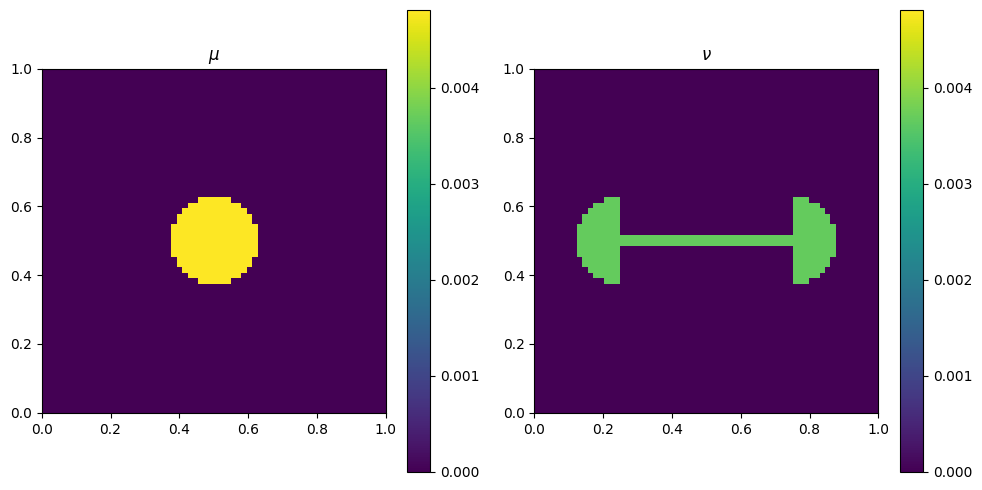

In [2]:
# %% Example: Caffarelli's counterexample (adapted from the reference implementation example)
# Grid of size n1 x n2
n1 = 64   # x axis
n2 = 64   # y axis

# cell-centered coordinates on [0,1]
xs = np.linspace(0.5/n1, 1-0.5/n1, n1)
ys = np.linspace(0.5/n2, 1-0.5/n2, n2)
x, y = np.meshgrid(xs, ys)

# initial quadratic potentials (as in the example)
phi_np = 0.5 * (x*x + y*y)
psi_np = 0.5 * (x*x + y*y)

# Initialize densities on (n2, n1) grid (note meshgrid ordering)
mu_np = np.zeros((n2, n1))
r = 0.125
mu_np[(x-0.5)**2 + (y-0.5)**2 < r**2] = 1
nu_np = np.zeros((n2, n1))
idx = (((x-0.25)**2 + (y-0.5)**2 < r**2) & (x < 0.25))
idx = idx | (((x-0.75)**2 + (y-0.5)**2 < r**2) & (x > 0.75))
idx = idx | ((x < 0.751) & (x > 0.249) & (y < 0.51) & (y > 0.49))
nu_np[idx] = 1

# Normalize to match discrete cell volumes (so total mass = 1 on the grid)
mu_np /= np.sum(mu_np)
nu_np /= np.sum(nu_np)

print(f"Total mass mu: {np.sum(mu_np):.6e}")
print(f"Total mass nu: {np.sum(nu_np):.6e}")
print(f"Max mu: {mu_np.max():.6e}, max nu: {nu_np.max():.6e}")

# convert to jax arrays (float64 for stability) and 1D coords for c-transform
mu = jnp.asarray(mu_np, dtype=jnp.float64)
nu = jnp.asarray(nu_np, dtype=jnp.float64)
phi = jnp.asarray(phi_np, dtype=jnp.float64)
psi = jnp.asarray(psi_np, dtype=jnp.float64)
coords = [jnp.asarray(xs, dtype=jnp.float64), jnp.asarray(ys, dtype=jnp.float64)]

# Plot mu and nu (quick check)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vmin = min(mu_np.min(), nu_np.min())
vmax = max(mu_np.max(), nu_np.max())
im0 = ax[0].imshow(mu_np, origin='lower', extent=(0, 1, 0, 1), vmin=vmin, vmax=vmax, cmap='viridis')
ax[0].set_title(r"$\mu$")
fig.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(nu_np, origin='lower', extent=(0, 1, 0, 1), vmin=vmin, vmax=vmax, cmap='viridis')
ax[1].set_title(r'$\nu$')
fig.colorbar(im1, ax=ax[1])
plt.tight_layout()

In [3]:
# Local copy of backnforth_sqeuclidean_nd from method.py, adapted to run in Python and record histories
# Refactored to keep the logic close to method.py while allowing different pushforward kernels (adaptive kernels)
def backnforth_sqeuclidean_nd_local(mu, nu, coords, stepsize, maxiterations, tolerance,
                                    progressbar=False, pushforward_fn=adaptive_pushforward_nd,
                                    stepsize_lower_bound=0.01, error_metric='h1_psi'):
    shape = mu.shape
    Ls = [c[-1] for c in coords]
    coords_t = tuple(jnp.asarray(c, dtype=mu.dtype) for c in coords)
    r2 = _r2_from_coords(coords_t).astype(mu.dtype)
    Lam = neumann_kernel_nd(shape, Ls, dtype=mu.dtype)
    cell_vol = jnp.prod(jnp.array([c[1] - c[0] for c in coords_t], dtype=mu.dtype))
    mu_nu_grid_sum = 0.5 * (r2 * (mu + nu)).sum()
    c_transform = partial(c_transform_quadratic_fast, coords_list=coords_t)

    def solve_neumann_poisson(f):
        f0 = f - f.mean()
        Fh = _dctn(f0)
        Uh = Fh / Lam
        Uh = Uh.at[(0,) * f.ndim].set(0.0)
        u = _idctn(Uh)
        return u - u.mean()

    def update_potential(phi, rho, target, sigma):
        residual = target - rho
        pde_solution = solve_neumann_poisson(residual)
        phi_new = phi + sigma * pde_solution
        grad_squared = (jnp.vdot(residual, pde_solution).real) * cell_vol
        return phi_new, grad_squared, pde_solution, residual

    def dual_value(phi, psi):
        return cell_vol * (mu_nu_grid_sum - (phi * mu).sum() - (psi * nu).sum())

    def stepsize_update(sigma, new_val, old_val, grad_sq,
                        upper=0.75, lower=0.25, scale_down=0.95):
        scale_up = 1.0 / scale_down
        gain = new_val - old_val
        sigma = jnp.where(gain > sigma * upper * grad_sq, sigma * scale_up, sigma)
        sigma = jnp.where(gain < sigma * lower * grad_sq, sigma * scale_down, sigma)
        sigma = jnp.maximum(sigma, stepsize_lower_bound)
        return sigma

    phi = jnp.zeros_like(mu)
    psi = jnp.zeros_like(nu)
    sigma = jnp.asarray(stepsize, dtype=mu.dtype)
    D_old = dual_value(phi, psi)

    history_lists = {
        'rho_mu': [],
        'rho_nu': [],
        'phi': [],
        'psi': [],
        'value': [],
        'sigma': [],
        'error': [],
        'pde_phi': [],
        'pde_psi': []
    }

    def record_half_step(stage, rho, pde_sol, grad_sq, dual_val, sigma_snapshot):
        if stage == 'phi':
            history_lists['rho_mu'].append(np.array(rho))
            history_lists['pde_phi'].append(np.array(pde_sol))
        else:
            history_lists['rho_nu'].append(np.array(rho))
            history_lists['pde_psi'].append(np.array(pde_sol))
        history_lists['phi'].append(np.array(phi))
        history_lists['psi'].append(np.array(psi))
        history_lists['value'].append(float(dual_val))
        history_lists['sigma'].append(float(sigma_snapshot))
        history_lists['error'].append(float(grad_sq))

    def run_half_step(stage):
        nonlocal phi, psi
        if stage == 'phi':
            source, target = mu, nu
            active, passive = phi, psi
        else:
            source, target = nu, mu
            active, passive = psi, phi
        rho, _ = pushforward_fn(source, -passive)
        active, grad_sq, pde_sol, _ = update_potential(active, rho, target, sigma)
        if stage == 'phi':
            phi = active
            psi = c_transform(phi)
        else:
            psi = active
            phi = c_transform(psi)
        dual_val = dual_value(phi, psi)
        return rho, pde_sol, grad_sq, dual_val

    for i in range(maxiterations):
        rho_mu, pde_phi_sol, gphi_sq, dual_phi = run_half_step('phi')
        record_half_step('phi', rho_mu, pde_phi_sol, gphi_sq, dual_phi, float(sigma))

        rho_nu, pde_psi_sol, gpsi_sq, dual_psi = run_half_step('psi')
        sigma = stepsize_update(sigma, dual_psi, D_old, gpsi_sq)
        D_old = dual_psi
        record_half_step('psi', rho_nu, pde_psi_sol, gpsi_sq, dual_psi, float(sigma))

        if progressbar and ((i + 1) % 5 == 0 or i == 0):
            print(f"iter {i:4d}: D={float(dual_psi):.6e}, sigma={float(sigma):.3e}, gpsi_sq={float(gpsi_sq):.6e}")

    def _stack_or_empty(key):
        data = history_lists[key]
        if not data:
            return np.empty((0,) + mu.shape)
        return np.stack(data)

    history = {
        'rho_mu': _stack_or_empty('rho_mu'),
        'rho_nu': _stack_or_empty('rho_nu'),
        'phi': _stack_or_empty('phi'),
        'psi': _stack_or_empty('psi'),
        'value': np.asarray(history_lists['value']),
        'sigma': np.asarray(history_lists['sigma']),
        'error': np.asarray(history_lists['error']),
        'pde_phi': _stack_or_empty('pde_phi'),
        'pde_psi': _stack_or_empty('pde_psi')
    }
    return phi, psi, history

# Run the local back-and-forth with the configurable pushforward (adaptive by default for this notebook)
maxiterations = 50
stepsize = 4 / np.maximum(np.max(mu_np), np.max(nu_np))
tolerance = 1e-8
selected_pushforward = adaptive_pushforward_nd
print(f"Running local solver with pushforward: {selected_pushforward.__name__}")
phi, psi, history = backnforth_sqeuclidean_nd_local(
    mu, nu, coords, stepsize, maxiterations, tolerance,
    progressbar=True, pushforward_fn=selected_pushforward)

# expose history cells for the plotting cell (convert to numpy where useful)
hist_rho_mu = history['rho_mu']
hist_rho_nu = history['rho_nu']
hist_phi = history['phi']
hist_psi = history['psi']
hist_dual = history['value']
hist_sigma = history['sigma']
hist_error = history['error']
# PDE solution histories
hist_pde_phi = history.get('pde_phi', np.array([]))
hist_pde_psi = history.get('pde_psi', np.array([]))

print('Completed local back-and-forth; recorded subiterations:', hist_phi.shape[0])

# Diagnostic checks: mass conservation and identity pushforward tests for both pushforwards
print('Mass checks:')
print('  sum mu (input):', float(mu.sum()))
print('  sum nu (input):', float(nu.sum()))
print('  sum last rho_mu (if any):', float(hist_rho_mu[-1].sum()) if hist_rho_mu.size > 0 else None)
print('  sum last rho_nu (if any):', float(hist_rho_nu[-1].sum()) if hist_rho_nu.size > 0 else None)

phi_test = 0.5 * (x*x + y*y)
rho_id_adaptive, _ = adaptive_pushforward_nd(mu, jnp.asarray(phi_test, dtype=mu.dtype))
print('Identity test (adaptive pushforward):', float(jnp.max(jnp.abs(rho_id_adaptive - mu))))


Running local solver with pushforward: adaptive_pushforward_nd
iter    0: D=1.462208e-04, sigma=8.758e+02, gpsi_sq=4.609701e-09
iter    4: D=1.447411e-04, sigma=7.133e+02, gpsi_sq=4.228416e-10
iter    9: D=1.447636e-04, sigma=5.520e+02, gpsi_sq=1.728622e-10
iter   14: D=1.448256e-04, sigma=4.271e+02, gpsi_sq=1.089727e-10
iter   19: D=1.448375e-04, sigma=3.305e+02, gpsi_sq=9.145813e-11
iter   24: D=1.448357e-04, sigma=2.557e+02, gpsi_sq=8.011717e-11
iter   29: D=1.448308e-04, sigma=1.979e+02, gpsi_sq=6.835307e-11
iter   34: D=1.448251e-04, sigma=1.531e+02, gpsi_sq=5.384801e-11
iter   39: D=1.448208e-04, sigma=1.185e+02, gpsi_sq=4.402063e-11
iter   44: D=1.448253e-04, sigma=9.167e+01, gpsi_sq=4.403554e-11
iter   49: D=1.448298e-04, sigma=7.860e+01, gpsi_sq=4.447578e-11
Completed local back-and-forth; recorded subiterations: 100
Mass checks:
  sum mu (input): 1.0000000000000009
  sum nu (input): 0.9999999999999982
  sum last rho_mu (if any): 1.0000000000000009
  sum last rho_nu (if any): 

/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_88760/4121186116.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 1, 0.97))


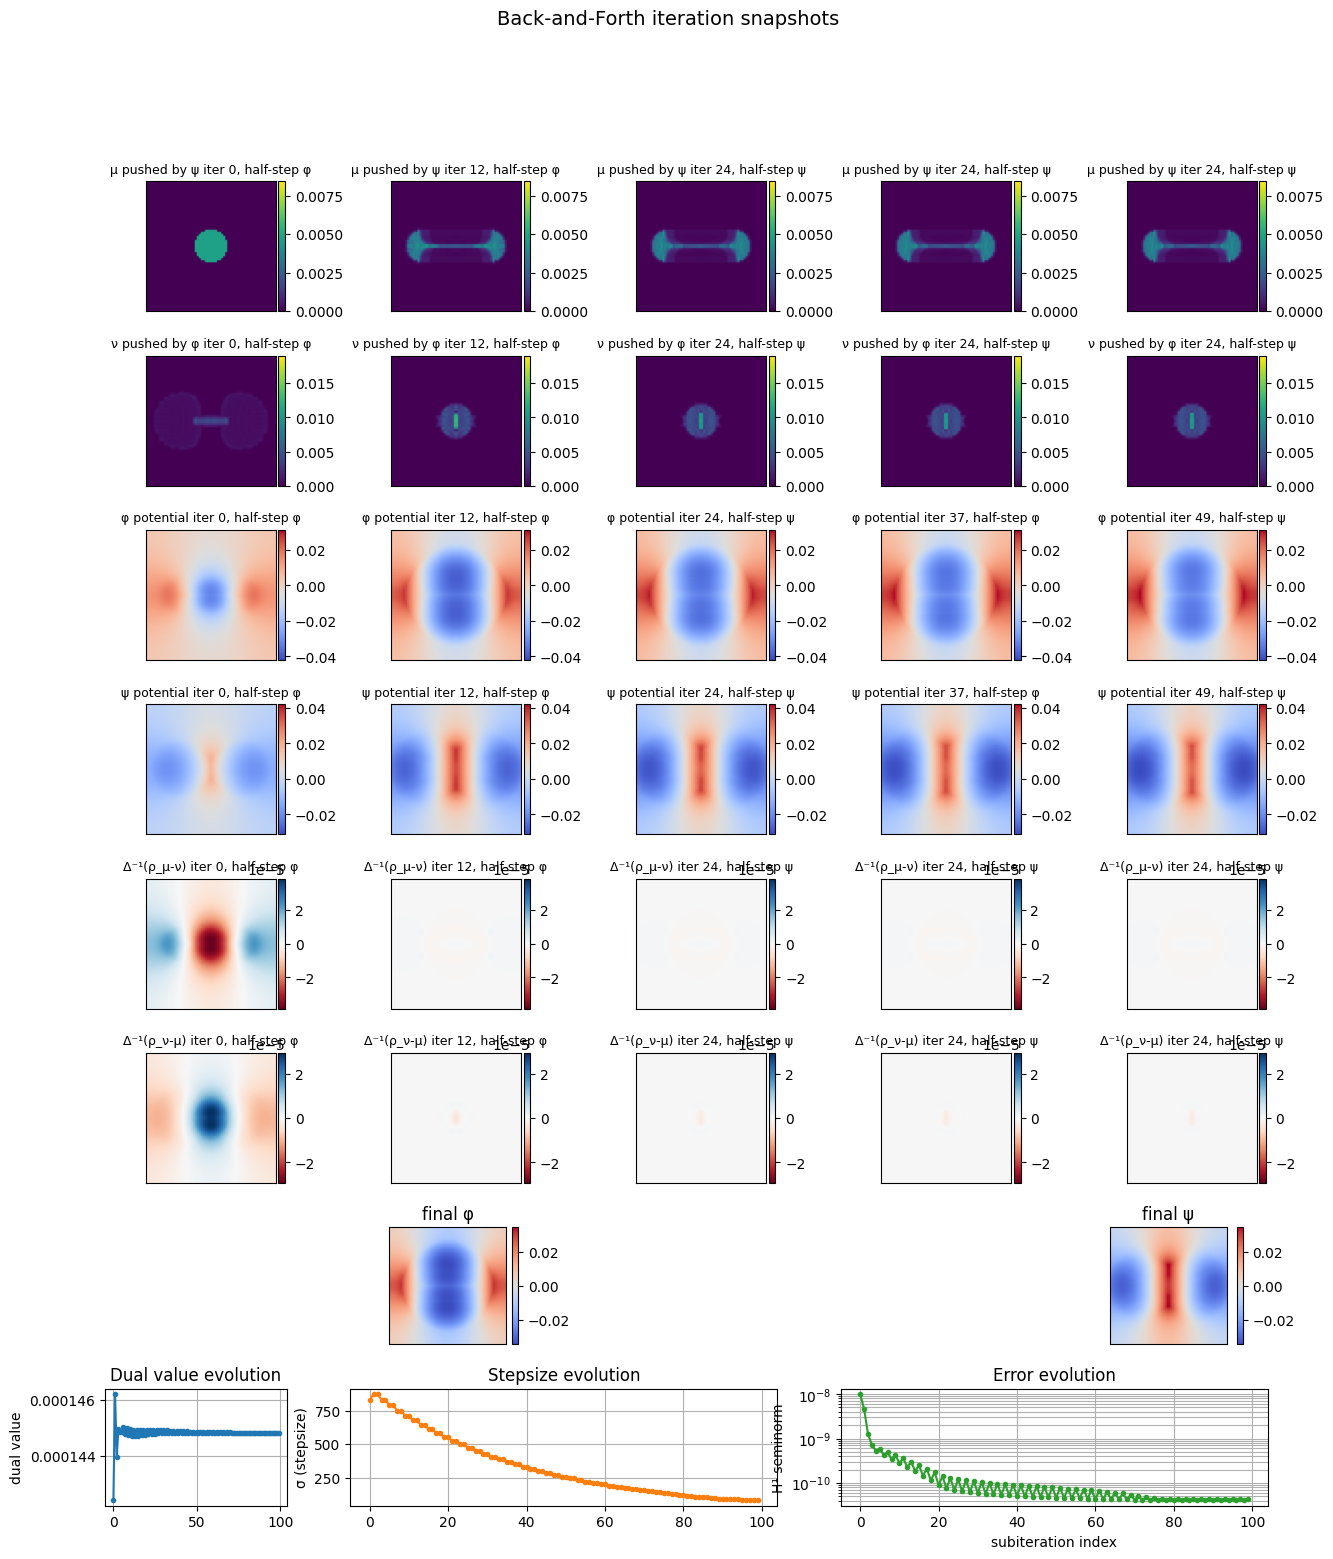

In [4]:
# Visualization helpers for history snapshots and diagnostics (including PDE solves)
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

MAX_SNAPSHOTS = 5


def _pick_snapshot_indices(length, max_panels=MAX_SNAPSHOTS):
    if length == 0:
        return np.array([], dtype=int)
    count = min(length, max_panels)
    return np.unique(np.linspace(0, length - 1, count, dtype=int))


def _subiteration_label(k):
    iteration = k // 2
    half = 'φ' if k % 2 == 0 else 'ψ'
    return f"iter {iteration}, half-step {half}"


def _row_norm(arr, center_zero=False):
    if arr.size == 0:
        return None
    if center_zero:
        vmax = float(np.abs(arr).max()) or 1.0
        return mcolors.TwoSlopeNorm(vcenter=0.0, vmin=-vmax, vmax=vmax)
    vmin = float(arr.min())
    vmax = float(arr.max())
    if np.isclose(vmax, vmin):
        vmax = vmin + 1e-6
    return mcolors.Normalize(vmin=vmin, vmax=vmax)


def _imshow_row(axs, data, idxs, title_prefix, cmap='viridis', center_zero=False):
    arr = np.asarray(data)
    if arr.size == 0 or idxs.size == 0:
        axs[0].text(0.5, 0.5, f'no {title_prefix} history', ha='center', va='center')
        for ax in axs:
            ax.set_axis_off()
        return
    norm = _row_norm(arr, center_zero=center_zero)
    for ax, idx in zip(axs, idxs):
        clamped = min(int(idx), arr.shape[0] - 1)
        im = ax.imshow(arr[clamped], origin='lower', extent=(0, 1, 0, 1), cmap=cmap, norm=norm)
        ax.set_title(f"{title_prefix} {_subiteration_label(clamped)}", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.015)
    for ax in axs[len(idxs):]:
        ax.set_axis_off()


def plot_history_overview(history, phi, psi):
    rho_mu = history.get('rho_mu', np.empty((0,) + phi.shape))
    rho_nu = history.get('rho_nu', np.empty((0,) + phi.shape))
    phi_hist = history.get('phi', np.empty((0,) + phi.shape))
    psi_hist = history.get('psi', np.empty((0,) + phi.shape))
    pde_phi = history.get('pde_phi', np.empty((0,) + phi.shape))
    pde_psi = history.get('pde_psi', np.empty((0,) + phi.shape))
    dual = np.asarray(history.get('value', np.array([])))
    sigma = np.asarray(history.get('sigma', np.array([])))
    error = np.asarray(history.get('error', np.array([])))

    max_len = max(len(rho_mu), len(rho_nu), len(phi_hist), len(psi_hist), len(pde_phi), len(pde_psi))
    idxs = _pick_snapshot_indices(max_len)
    num_cols = max(len(idxs), 2)

    row_specs = [
        ('μ pushed by ψ', rho_mu, 'viridis', False),
        ('ν pushed by φ', rho_nu, 'viridis', False),
        ('φ potential', phi_hist, 'coolwarm', False),
        ('ψ potential', psi_hist, 'coolwarm', False),
        ('Δ⁻¹(ρ_μ-ν)', pde_phi, 'RdBu', True),
        ('Δ⁻¹(ρ_ν-μ)', pde_psi, 'RdBu', True),
    ]
    num_rows = len(row_specs) + 2  # final potentials + diagnostics

    fig_height = 2.2 * len(row_specs) + 4
    fig = plt.figure(figsize=(3 * num_cols, fig_height))
    gs = gridspec.GridSpec(num_rows, num_cols,
                           height_ratios=[1] * len(row_specs) + [0.9, 0.9],
                           hspace=0.35, wspace=0.35)

    for row, (title_prefix, data, cmap, center_zero) in enumerate(row_specs):
        axs = [fig.add_subplot(gs[row, col]) for col in range(num_cols)]
        _imshow_row(axs, data, idxs, title_prefix, cmap=cmap, center_zero=center_zero)

    split = max(1, num_cols // 2)
    pot_norm = mcolors.TwoSlopeNorm(vcenter=0.0,
                                    vmin=float(min(phi.min(), psi.min())),
                                    vmax=float(max(phi.max(), psi.max())))
    ax_phi = fig.add_subplot(gs[len(row_specs), :split])
    im_phi = ax_phi.imshow(np.asarray(phi), origin='lower', extent=(0, 1, 0, 1), cmap='coolwarm', norm=pot_norm)
    ax_phi.set_title('final φ')
    ax_phi.set_xticks([]); ax_phi.set_yticks([])
    plt.colorbar(im_phi, ax=ax_phi, fraction=0.046, pad=0.015)

    ax_psi = fig.add_subplot(gs[len(row_specs), split:])
    if split == num_cols:
        ax_psi.set_axis_off()
    else:
        im_psi = ax_psi.imshow(np.asarray(psi), origin='lower', extent=(0, 1, 0, 1), cmap='coolwarm', norm=pot_norm)
        ax_psi.set_title('final ψ')
        ax_psi.set_xticks([]); ax_psi.set_yticks([])
        plt.colorbar(im_psi, ax=ax_psi, fraction=0.046, pad=0.015)

    thirds = max(1, num_cols // 3)
    two_thirds = max(thirds + 1, 2 * num_cols // 3)
    last_row = len(row_specs) + 1

    ax_val = fig.add_subplot(gs[last_row, :thirds])
    if dual.size:
        ax_val.plot(dual, '-o', markersize=3)
        ax_val.set_ylabel('dual value')
    else:
        ax_val.text(0.5, 0.6, 'no dual history', ha='center')
    ax_val.set_title('Dual value evolution')
    ax_val.grid(True)

    ax_sig = fig.add_subplot(gs[last_row, thirds:two_thirds])
    if sigma.size:
        ax_sig.plot(sigma, '-o', markersize=3, color='C1')
        ax_sig.set_ylabel('σ (stepsize)')
    else:
        ax_sig.text(0.5, 0.6, 'no σ history', ha='center')
    ax_sig.set_title('Stepsize evolution')
    ax_sig.grid(True)

    ax_err = fig.add_subplot(gs[last_row, two_thirds:])
    if error.size:
        ax_err.plot(np.clip(error, 1e-12, None), '-o', markersize=3, color='C2')
        ax_err.set_yscale('log')
        ax_err.set_ylabel('H¹ seminorm')
    else:
        ax_err.text(0.5, 0.6, 'no error history', ha='center')
    ax_err.set_title('Error evolution')
    ax_err.set_xlabel('subiteration index')
    ax_err.grid(True, which='both')

    fig.suptitle('Back-and-Forth iteration snapshots', fontsize=14)
    plt.tight_layout(rect=(0, 0, 1, 0.97))
    plt.show()


plot_history_overview(history, phi, psi)


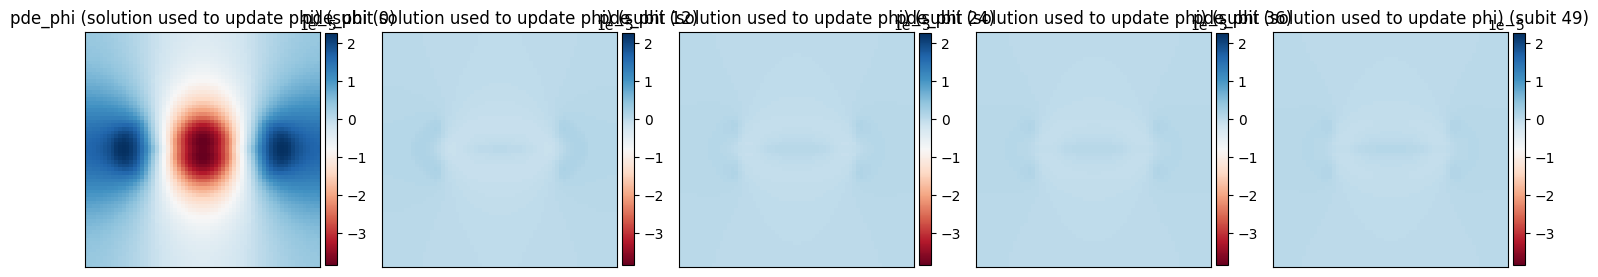

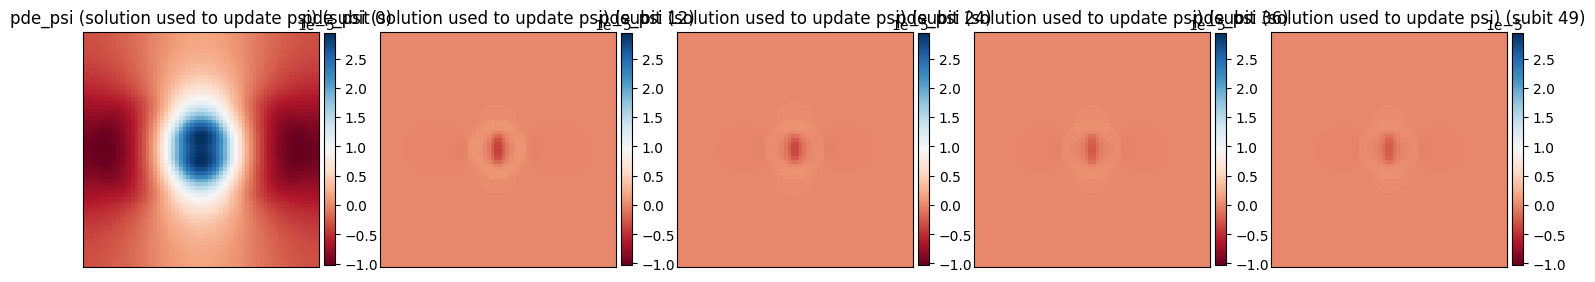

In [5]:
# New cell: plot PDE solution snapshots (pde_phi and pde_psi recorded during the tracer)
import matplotlib.pyplot as plt

# convert histories to numpy arrays (they were set above)
pde_phi = np.asarray(hist_pde_phi)
pde_psi = np.asarray(hist_pde_psi)

def plot_pde_snapshots(pde_hist, title_prefix):
    m = pde_hist.shape[0]
    if m == 0:
        print(f'No {title_prefix} history to plot')
        return
    num_snap = min(5, m)
    idxs = np.unique(np.linspace(0, m - 1, num_snap, dtype=int))
    fig, axes = plt.subplots(1, len(idxs), figsize=(3 * len(idxs), 3))
    if len(idxs) == 1:
        axes = [axes]
    vmin = pde_hist.min()
    vmax = pde_hist.max()
    for ax, ii in zip(axes, idxs):
        im = ax.imshow(pde_hist[ii], origin='lower', extent=(0,1,0,1), vmin=vmin, vmax=vmax, cmap='RdBu')
        ax.set_title(f'{title_prefix} (subit {ii})')
        ax.set_xticks([]); ax.set_yticks([])
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    plt.tight_layout()
    plt.show()

plot_pde_snapshots(pde_phi, 'pde_phi (solution used to update phi)')
plot_pde_snapshots(pde_psi, 'pde_psi (solution used to update psi)')

<>:31: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
<>:31: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_88760/2846866020.py:31: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
  ax[0].set_title('$\mu$ (smooth)')
/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_88760/2846866020.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


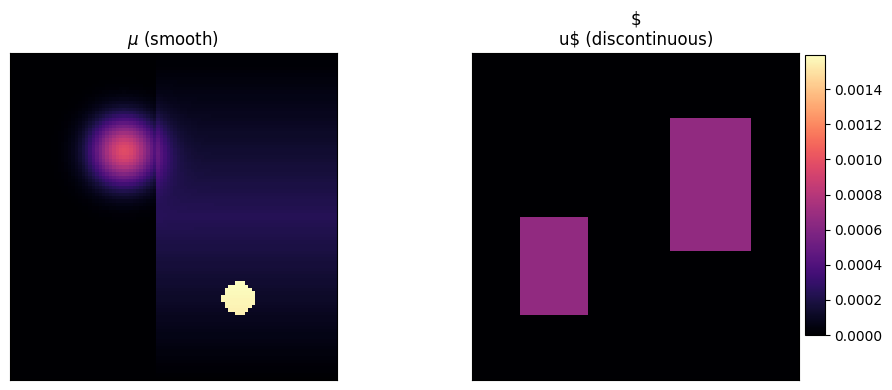

In [6]:

# Additional example: smooth vs discontinuous target
n1 = n2 = 96
xs = np.linspace(0.5/n1, 1 - 0.5/n1, n1)
ys = np.linspace(0.5/n2, 1 - 0.5/n2, n2)
x, y = np.meshgrid(xs, ys)

def gaussian(cx, cy, scale):
    return np.exp(-((x - cx)**2 + (y - cy)**2) / scale)

mu_np = 0.8 * gaussian(0.35, 0.7, 0.01)
mu_np += 1.2 * (((x - 0.7)**2 + (y - 0.25)**2) < 0.05**2).astype(float)
mu_np += 0.2 * np.clip(1 - np.abs(2 * (y - 0.5)), 0, 1) * (x > 0.45)

nu_np = np.zeros_like(x)
nu_np[(x>0.15)&(x<0.35)&(y>0.2)&(y<0.5)] = 1
nu_np[(x>0.6)&(x<0.85)&(y>0.4)&(y<0.8)] = 1

mu_np = np.clip(mu_np, 0, None)
nu_np = np.clip(nu_np, 0, None)
mu_np /= np.sum(mu_np)
nu_np /= np.sum(nu_np)

mu = jnp.asarray(mu_np, dtype=jnp.float64)
nu = jnp.asarray(nu_np, dtype=jnp.float64)
coords = [jnp.asarray(xs, dtype=jnp.float64), jnp.asarray(ys, dtype=jnp.float64)]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
vmin = min(mu_np.min(), nu_np.min())
vmax = max(mu_np.max(), nu_np.max())
im0 = ax[0].imshow(mu_np, origin='lower', extent=(0,1,0,1), cmap='magma', vmin=vmin, vmax=vmax)
ax[0].set_title('$\mu$ (smooth)')
im1 = ax[1].imshow(nu_np, origin='lower', extent=(0,1,0,1), cmap='magma', vmin=vmin, vmax=vmax)
ax[1].set_title('$\nu$ (discontinuous)')
for a in ax:
    a.set_xticks([]); a.set_yticks([])
fig.subplots_adjust(right=0.88, wspace=0.05)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(im0, cax=cbar_ax)
plt.tight_layout()
plt.show()


In [7]:

stepsize = 4 / max(mu_np.max(), nu_np.max())
maxiterations = 80
tolerance = 1e-10
phi, psi, history = backnforth_sqeuclidean_nd_local(
    mu, nu, coords,
    stepsize=stepsize,
    maxiterations=maxiterations,
    tolerance=tolerance,
    progressbar=True,
    pushforward_fn=adaptive_pushforward_nd)

hist_rho_mu = history['rho_mu']
hist_rho_nu = history['rho_nu']
hist_dual = history['value']
hist_sigma = history['sigma']


iter    0: D=7.913207e-05, sigma=2.640e+03, gpsi_sq=3.628871e-10
iter    4: D=8.133306e-05, sigma=3.241e+03, gpsi_sq=2.538904e-12
iter    9: D=8.182371e-05, sigma=4.189e+03, gpsi_sq=4.475676e-12
iter   14: D=8.196657e-05, sigma=4.641e+03, gpsi_sq=1.389398e-11
iter   19: D=8.209082e-05, sigma=4.641e+03, gpsi_sq=1.414157e-11
iter   24: D=8.216546e-05, sigma=4.189e+03, gpsi_sq=1.101559e-11
iter   29: D=8.224840e-05, sigma=4.409e+03, gpsi_sq=9.162816e-12
iter   34: D=8.229140e-05, sigma=3.979e+03, gpsi_sq=7.703165e-12
iter   39: D=8.236090e-05, sigma=3.979e+03, gpsi_sq=5.144968e-12
iter   44: D=8.238793e-05, sigma=3.780e+03, gpsi_sq=5.504609e-12
iter   49: D=8.242729e-05, sigma=3.979e+03, gpsi_sq=5.060700e-12
iter   54: D=8.244757e-05, sigma=3.591e+03, gpsi_sq=4.009995e-12
iter   59: D=8.247712e-05, sigma=3.780e+03, gpsi_sq=3.255338e-12
iter   64: D=8.249788e-05, sigma=3.780e+03, gpsi_sq=2.843729e-12
iter   69: D=8.251571e-05, sigma=3.591e+03, gpsi_sq=2.334382e-12
iter   74: D=8.253194e-05

/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_88760/1917918375.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


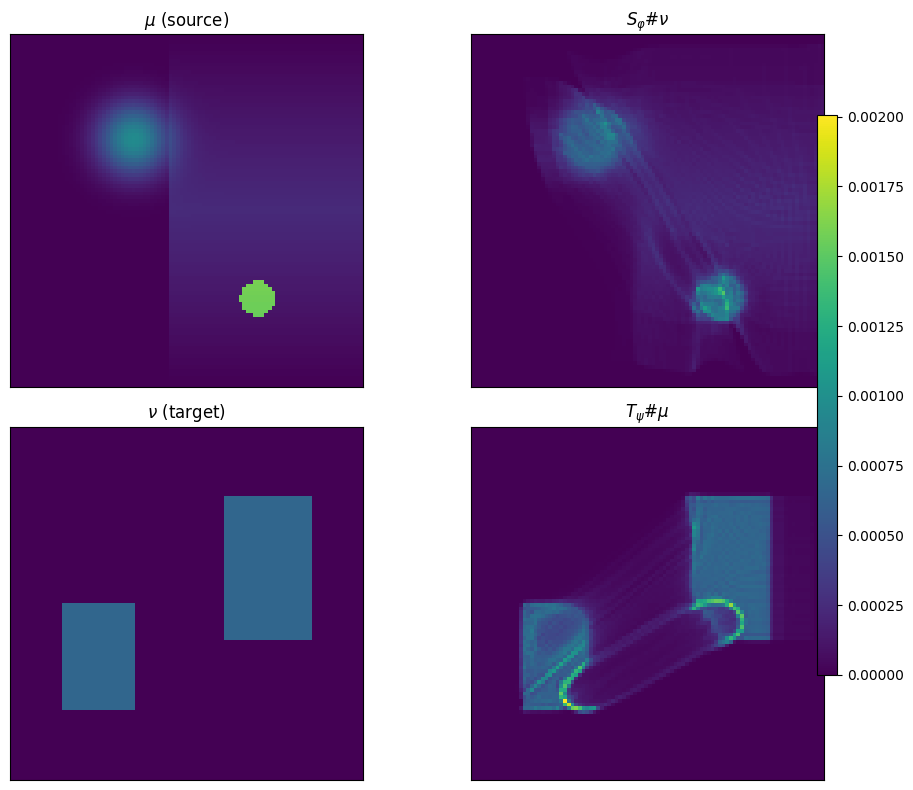

In [9]:
# Pushforward diagnostics for smooth/discontinuous case
if hist_rho_mu.size:
    rho_mu_final = hist_rho_mu[-1]
    rho_nu_final = hist_rho_nu[-1]
    vmin = min(mu_np.min(), nu_np.min(), rho_mu_final.min(), rho_nu_final.min())
    vmax = max(mu_np.max(), nu_np.max(), rho_mu_final.max(), rho_nu_final.max())
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    entries = [
        (ax[0,0], mu_np, r'$\mu$ (source)'),
        (ax[0,1], rho_nu_final, r'$S_{\varphi}\#\nu$'),
        (ax[1,0], nu_np, r'$\nu$ (target)'),
        (ax[1,1], rho_mu_final, r'$T_{\psi}\#\mu$'),
    ]
    for axi, data, lbl in entries:
        im = axi.imshow(data, origin='lower', extent=(0,1,0,1), cmap='viridis', vmin=vmin, vmax=vmax)
        axi.set_title(lbl)
        axi.set_xticks([]); axi.set_yticks([])
    fig.subplots_adjust(right=0.88)
    cax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cax)
    plt.tight_layout()
    plt.show()
